In [47]:
%load_ext autoreload
%autoreload 2


import torch.nn as nn
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torch.utils.data import Subset
from training import train_loop
from utils import plot_history

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# CelebA

## Smile detection

In [37]:
def get_smile(attr):
    return attr[18].float().unsqueeze(0)


transform_train = transforms.Compose([
    transforms.RandomCrop([178, 178]),
    transforms.RandomHorizontalFlip(),
    transforms.Resize([64, 64]),
    transforms.ToTensor(),
])


transform = transforms.Compose([
    transforms.CenterCrop([178, 178]),
    transforms.Resize([64, 64]),
    transforms.ToTensor(),
])


In [38]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cuda:0'

In [39]:
image_path = "../data"

celeba_train_dataset = torchvision.datasets.CelebA(
    image_path, split='train',
    target_type='attr', download=True,
    transform=transform_train, target_transform=get_smile
)

celeba_valid_dataset = torchvision.datasets.CelebA(
    image_path, split='valid',
    target_type='attr', download=True,
    transform=transform, target_transform=get_smile
)

celeba_test_dataset = torchvision.datasets.CelebA(
    image_path, split='test',
    target_type='attr', download=True,
    transform=transform, target_transform=get_smile
)


print(f"Dataset size: \nTrain: {len(celeba_train_dataset)}\nValid: {len(celeba_valid_dataset)}\nTest:  {len(celeba_test_dataset)}")


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Dataset size: 
Train: 162770
Valid: 19867
Test:  19962


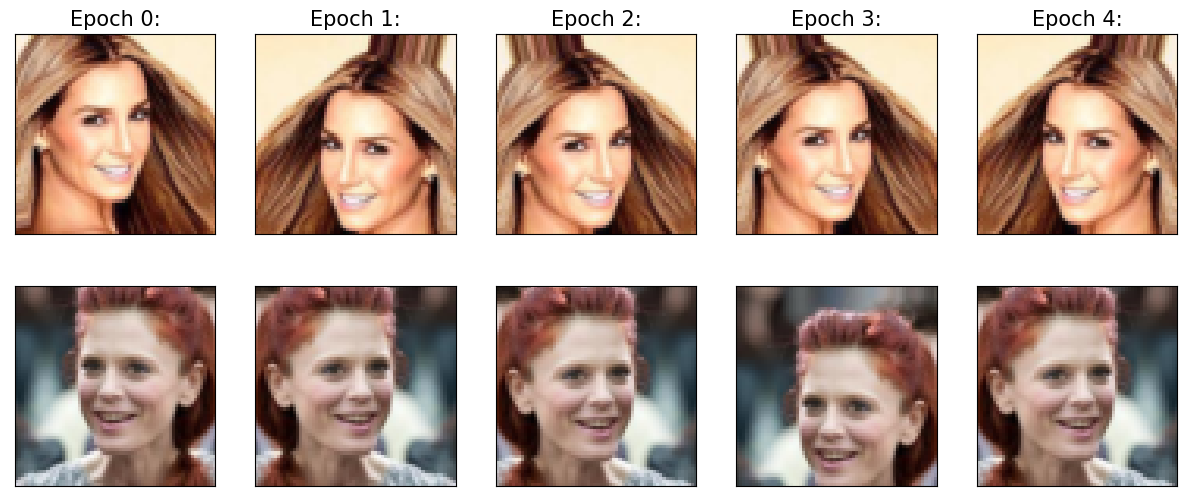

In [40]:
torch.manual_seed(1)
data_loader = DataLoader(celeba_train_dataset, batch_size=2)
fig = plt.figure(figsize=(15, 6))
num_epochs = 5
for j in range(num_epochs):
    img_batch, label_batch = next(iter(data_loader))
    img = img_batch[0]
    ax = fig.add_subplot(2, 5, j + 1)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f'Epoch {j}:', size=15)
    ax.imshow(img.permute(1, 2, 0))

    img = img_batch[1]
    ax = fig.add_subplot(2, 5, j + 6)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(img.permute(1, 2, 0))

plt.show()

In [41]:
celeba_train_dataset = Subset(celeba_train_dataset, torch.arange(16000))
celeba_valid_dataset = Subset(celeba_valid_dataset, torch.arange(1000))

print('Train set:', len(celeba_train_dataset))
print('Validation set:', len(celeba_valid_dataset))

Train set: 16000
Validation set: 1000


In [42]:
batch_size = 64

train_dl = DataLoader(celeba_train_dataset, batch_size, shuffle=True)
valid_dl = DataLoader(celeba_valid_dataset,batch_size, shuffle=False)
test_dl = DataLoader(celeba_test_dataset, batch_size, shuffle=False)

In [52]:
def convolution_model():
    model = nn.Sequential()
    model.add_module(
        "conv1", nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
    )
    model.add_module("relu1", nn.ReLU())
    model.add_module("pool1", nn.MaxPool2d(kernel_size=2))
    model.add_module("dropout1", nn.Dropout(p=0.5))

    model.add_module(
        "conv2", nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
    )
    model.add_module("relu2", nn.ReLU())
    model.add_module("pool2", nn.MaxPool2d(kernel_size=2))
    model.add_module("dropout2", nn.Dropout(p=0.5))

    model.add_module(
        "conv3", nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
    )
    model.add_module("relu3", nn.ReLU())
    model.add_module("pool3", nn.MaxPool2d(kernel_size=2))

    model.add_module(
        "conv4", nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
    )
    model.add_module("relu4", nn.ReLU())
    model.add_module("pool4", nn.AvgPool2d(kernel_size=8))
    model.add_module("flatten", nn.Flatten())
    model.add_module("fc", nn.Linear(256, 1))
    return model

model = convolution_model()
model

Sequential(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.5, inplace=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3): ReLU()
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu4): ReLU()
  (pool4): AvgPool2d(kernel_size=8, stride=8, padding=0)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc): Linear(in_features=256, out_features=1, bias=True)
)

In [53]:
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
torch.manual_seed(1)
history = train_loop(train_dl, model, optimizer=optimizer, val_dataloader=valid_dl, num_epochs=30, binary=True, verbose=True)

Epoch 1/30
Train loss: 0.660078, accuracy: 61.43%
Validation loss:  0.644796, accuracy: 61.00%
-----------------------------
Epoch 2/30
Train loss: 0.592090, accuracy: 68.66%
Validation loss:  0.589669, accuracy: 70.80%
-----------------------------
Epoch 3/30
Train loss: 0.562137, accuracy: 71.52%
Validation loss:  0.534824, accuracy: 74.70%
-----------------------------
Epoch 4/30
Train loss: 0.542090, accuracy: 72.88%
Validation loss:  0.515178, accuracy: 76.90%
-----------------------------
Epoch 5/30
Train loss: 0.514424, accuracy: 74.40%
Validation loss:  0.463650, accuracy: 78.90%
-----------------------------
Epoch 6/30
Train loss: 0.488288, accuracy: 76.31%
Validation loss:  0.458211, accuracy: 79.10%
-----------------------------
Epoch 7/30
Train loss: 0.469613, accuracy: 77.39%
Validation loss:  0.441616, accuracy: 80.90%
-----------------------------
Epoch 8/30
Train loss: 0.449987, accuracy: 78.51%
Validation loss:  0.411541, accuracy: 81.00%
-----------------------------


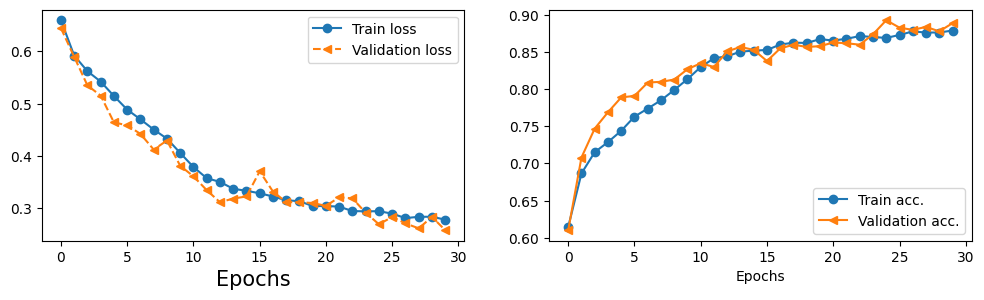

In [54]:
plot_history(history)

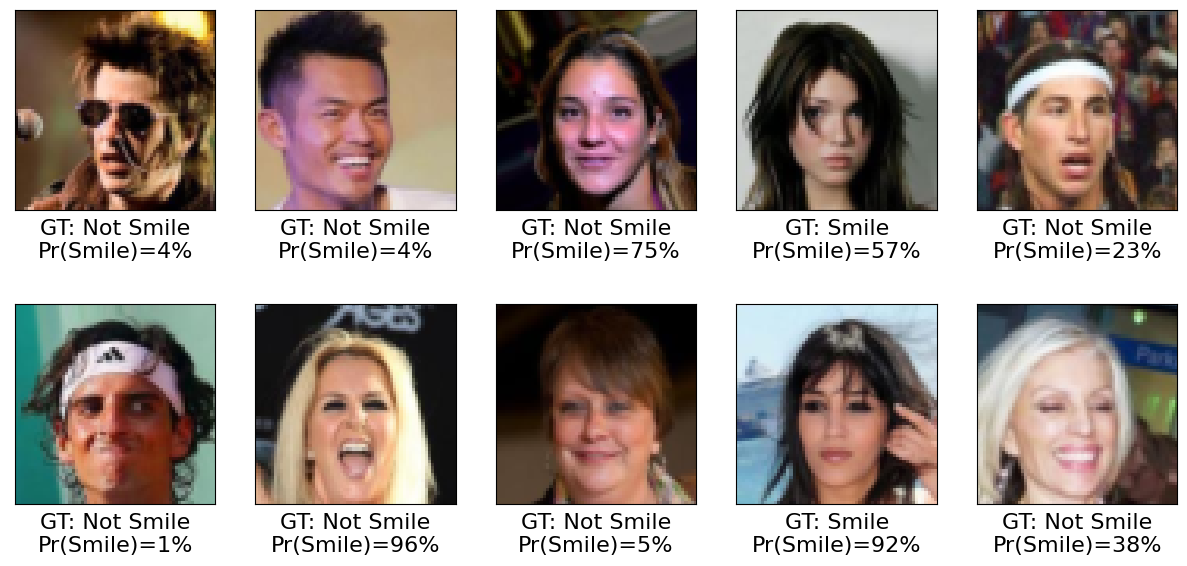

In [57]:
x_batch, y_batch = next(iter(test_dl))

model = model.cpu()

pred = torch.sigmoid(model(x_batch)[:, 0]) * 100
fig = plt.figure(figsize=(15, 7))
for j in range(10, 20):
    ax = fig.add_subplot(2, 5, j - 10 + 1)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(x_batch[j].permute(1, 2, 0))
    if y_batch[j] == 1:
        label = "Smile"
    else:
        label = "Not Smile"

    ax.text(
        0.5,
        -0.15,
        f"GT: {label:s}\nPr(Smile)={pred[j]:.0f}%",
        size=16,
        horizontalalignment="center",
        verticalalignment="center",
        transform=ax.transAxes,
    )
plt.show()

In [75]:
def get_male(attr):
    return attr[20].float().unsqueeze(0)


celeba_train_dataset = torchvision.datasets.CelebA(
    image_path, split='train',
    target_type='attr', download=True,
    transform=transform_train, target_transform=get_male
)


celeba_valid_dataset = torchvision.datasets.CelebA(
    image_path, split='valid',
    target_type='attr', download=True,
    transform=transform, target_transform=get_male
)

celeba_test_dataset = torchvision.datasets.CelebA(
    image_path, split='test',
    target_type='attr', download=True,
    transform=transform, target_transform=get_male
)

celeba_train_dataset = Subset(celeba_train_dataset, torch.arange(16000))
celeba_valid_dataset = Subset(celeba_valid_dataset, torch.arange(1000))


batch_size = 64

train_dl = DataLoader(celeba_train_dataset, batch_size, shuffle=True)
valid_dl = DataLoader(celeba_valid_dataset,batch_size, shuffle=False)
test_dl = DataLoader(celeba_test_dataset, batch_size, shuffle=False)


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [76]:
sex_classifier = nn.Sequential(*list(model.children())[:-1])
last_layer = nn.Linear(256, 1)
sex_classifier.add_module('linear', last_layer)
sex_classifier = sex_classifier.to(device)
sex_classifier

Sequential(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Dropout(p=0.5, inplace=False)
  (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (5): ReLU()
  (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (7): Dropout(p=0.5, inplace=False)
  (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): ReLU()
  (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (11): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (12): ReLU()
  (13): AvgPool2d(kernel_size=8, stride=8, padding=0)
  (14): Flatten(start_dim=1, end_dim=-1)
  (linear): Linear(in_features=256, out_features=1, bias=True)
)

In [78]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
history = train_loop(train_dl, model, optimizer=optimizer, val_dataloader=valid_dl, num_epochs=30, binary=True, verbose=True)

Epoch 1/30
Train loss: 0.618543, accuracy: 67.21%
Validation loss:  0.495186, accuracy: 77.20%
-----------------------------
Epoch 2/30
Train loss: 0.474524, accuracy: 77.48%
Validation loss:  0.383870, accuracy: 84.70%
-----------------------------
Epoch 3/30
Train loss: 0.391958, accuracy: 82.16%
Validation loss:  0.274472, accuracy: 89.80%
-----------------------------
Epoch 4/30
Train loss: 0.293935, accuracy: 87.41%
Validation loss:  0.260948, accuracy: 88.40%
-----------------------------
Epoch 5/30
Train loss: 0.258753, accuracy: 88.93%
Validation loss:  0.223473, accuracy: 90.00%
-----------------------------
Epoch 6/30
Train loss: 0.238947, accuracy: 90.06%
Validation loss:  0.165103, accuracy: 93.50%
-----------------------------
Epoch 7/30
Train loss: 0.228022, accuracy: 90.22%
Validation loss:  0.176791, accuracy: 92.50%
-----------------------------
Epoch 8/30
Train loss: 0.213175, accuracy: 91.09%
Validation loss:  0.136971, accuracy: 95.30%
-----------------------------


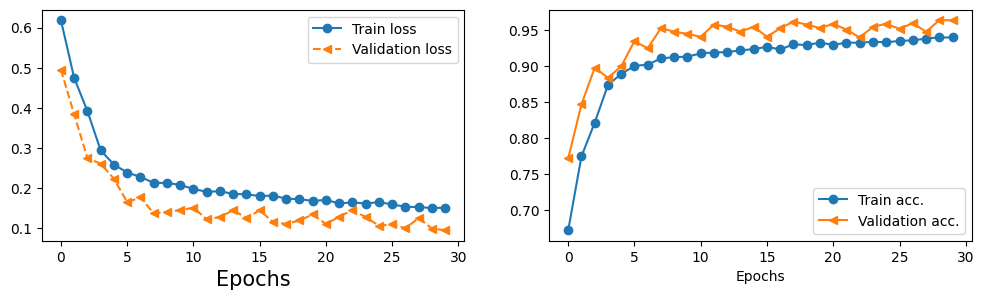

In [79]:
plot_history(history)

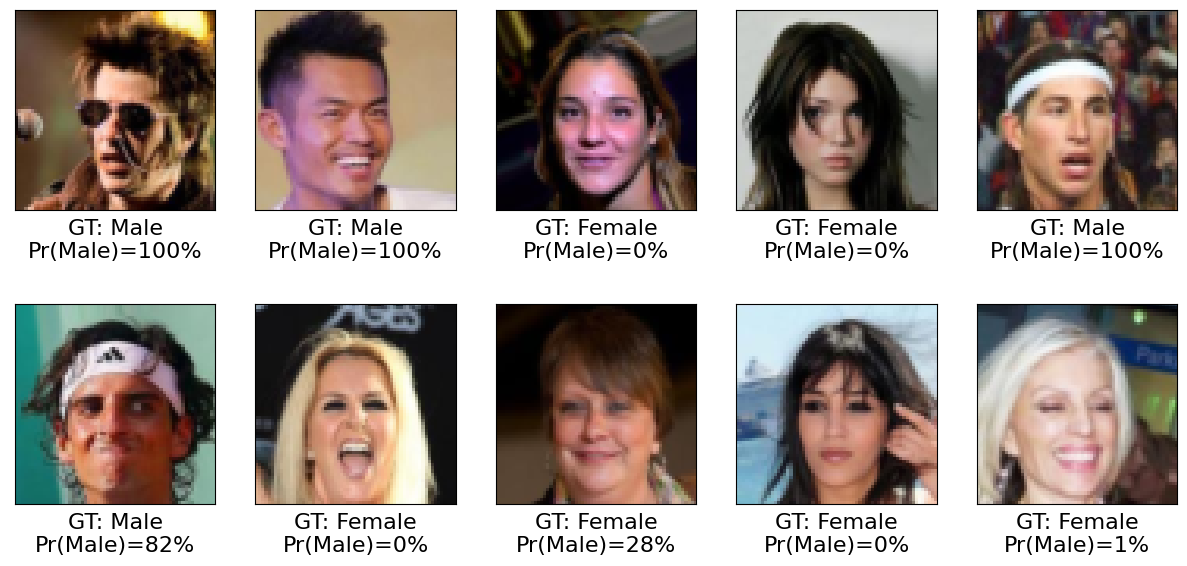

In [80]:
x_batch, y_batch = next(iter(test_dl))

model = model.cpu()

pred = torch.sigmoid(model(x_batch)[:, 0]) * 100
fig = plt.figure(figsize=(15, 7))
for j in range(10, 20):
    ax = fig.add_subplot(2, 5, j - 10 + 1)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(x_batch[j].permute(1, 2, 0))
    if y_batch[j] == 1:
        label = "Male"
    else:
        label = "Female"

    ax.text(
        0.5,
        -0.15,
        f"GT: {label:s}\nPr(Male)={pred[j]:.0f}%",
        size=16,
        horizontalalignment="center",
        verticalalignment="center",
        transform=ax.transAxes,
    )
plt.show()